In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
import keras

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0


In [3]:
from tensorflow.keras.layers import Input, Lambda, Conv2D, Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import os
import numpy as np
import pandas as pd
import shutil
from glob import glob
import matplotlib.pyplot as plt
import random
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [4]:
# re-size all the images to this
image_size = 224
batch_size = 32

source_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset"
train_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Test"
validate_dir = "/content/drive/MyDrive/Colab Notebooks/Dataset/Validate"

# Define data generators for train, validation, and test sets
Train_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
Val_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)
Test_Datagen = ImageDataGenerator(dtype='float32', preprocessing_function=tf.keras.applications.vgg16.preprocess_input)

# Create train, validation, and test generators
batch_size = 32
train_generator = Train_Datagen.flow_from_directory(train_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
val_generator = Val_Datagen.flow_from_directory(validate_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')
test_generator = Test_Datagen.flow_from_directory(test_dir, target_size=(224, 224), batch_size=batch_size, class_mode='binary')

Found 961 images belonging to 2 classes.
Found 193 images belonging to 2 classes.
Found 186 images belonging to 2 classes.


In [5]:
# Get a batch of data from the generator
batch_train_images, batch_train_labels = next(train_generator)
batch_val_images, batch_val_labels = next(val_generator)
batch_test_images, batch_test_labels = next(test_generator)

# Check the shape of the batch data
print("Shape of training batch images:", batch_train_images.shape)
print("Shape of training batch labels:", batch_train_labels.shape)
print("Shape of validation batch images:", batch_val_images.shape)
print("Shape of validation batch labels:", batch_val_labels.shape)
print("Shape of testing batch images:", batch_test_images.shape)
print("Shape of testing batch labels:", batch_test_labels.shape)

Shape of training batch images: (32, 224, 224, 3)
Shape of training batch labels: (32,)
Shape of validation batch images: (32, 224, 224, 3)
Shape of validation batch labels: (32,)
Shape of testing batch images: (32, 224, 224, 3)
Shape of testing batch labels: (32,)


In [6]:
train_generator.class_indices

{'no': 0, 'yes': 1}

In [8]:
from tensorflow.keras.applications import VGG16

# Load pre-trained VGG16 model without top layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Create a Sequential model
model = Sequential()

# Add the VGG16 base model
model.add(base_model)

# Add Flatten layer
model.add(Flatten())

# Add Dense layers with Dropout for preventing overfitting
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()


58889256/58889256 [==============================] - 0s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                         

In [9]:
# Specify the path where you want to create the directory and file
checkpoint_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints'
os.makedirs(checkpoint_path, exist_ok=True)

In [10]:
# Define callbacks for model saving and logging
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_path, 'model_{epoch:02d}.h5'),
    save_weights_only=False,
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True,
    verbose=1
)


In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 1/50
30/30 [==============================] - ETA: 0s - loss: 10.9228 - accuracy: 0.6652 
Epoch 1: val_loss improved from inf to 0.49606, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_01.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 696s 23s/step - loss: 10.9228 - accuracy: 0.6652 - val_loss: 0.4961 - val_accuracy: 0.9531
Epoch 2/50
30/30 [==============================] - ETA: 0s - loss: 1.5393 - accuracy: 0.9010 
Epoch 2: val_loss did not improve from 0.49606
30/30 [==============================] - 670s 22s/step - loss: 1.5393 - accuracy: 0.9010 - val_loss: 0.7273 - val_accuracy: 0.9479
Epoch 3/50
30/30 [==============================] - ETA: 0s - loss: 0.9661 - accuracy: 0.9193 
Epoch 3: val_loss improved from 0.49606 to 0.32120, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_03.h5
30/30 [==============================] - 706s 24s/step - loss: 0.9661 - accuracy: 0.9193 - val_loss: 0.3212 - val_accuracy: 0.9792
Epoch 4/50
30/30 [==============================] - ETA: 0s - loss: 0.6835 - accuracy: 0.9376 
Epoch 4: val_loss improved from 0.32120 to 0.04597, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoi

In [11]:
latest_checkpoint = '/content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_31.h5'

model.load_weights(latest_checkpoint)

In [12]:
# Resume training from the fifth epoch
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.n // train_generator.batch_size,
    epochs=50,  # You can adjust the number of epochs as needed
    initial_epoch=31,  # Start from the fifth epoch
    validation_data=val_generator,
    validation_steps=val_generator.n // val_generator.batch_size,
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 32/50
30/30 [==============================] - ETA: 0s - loss: 0.2179 - accuracy: 0.9763 
Epoch 32: val_loss improved from inf to 0.03618, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_32.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


30/30 [==============================] - 692s 23s/step - loss: 0.2179 - accuracy: 0.9763 - val_loss: 0.0362 - val_accuracy: 0.9948
Epoch 33/50
30/30 [==============================] - ETA: 0s - loss: 0.2826 - accuracy: 0.9752 
Epoch 33: val_loss improved from 0.03618 to 0.00490, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_33.h5
30/30 [==============================] - 681s 23s/step - loss: 0.2826 - accuracy: 0.9752 - val_loss: 0.0049 - val_accuracy: 0.9948
Epoch 34/50
30/30 [==============================] - ETA: 0s - loss: 0.2122 - accuracy: 0.9731 
Epoch 34: val_loss improved from 0.00490 to 0.00009, saving model to /content/drive/MyDrive/Colab Notebooks/Dataset/vgg19_checkpoints/model_34.h5
30/30 [==============================] - 673s 23s/step - loss: 0.2122 - accuracy: 0.9731 - val_loss: 9.4488e-05 - val_accuracy: 1.0000
Epoch 35/50
30/30 [==============================] - ETA: 0s - loss: 0.1160 - accuracy: 0.9785 
Epoch 35: val_loss did 

In [13]:
# Save the model to Google Drive
model.save('/content/drive/MyDrive/Colab Notebooks/Dataset/Trained_model/model_vgg19_gen.h5')

In [14]:
# Evaluate the model on test data
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)


6/6 [==============================] - 114s 17s/step - loss: 1.8399e-06 - accuracy: 1.0000
Test Accuracy: 1.0


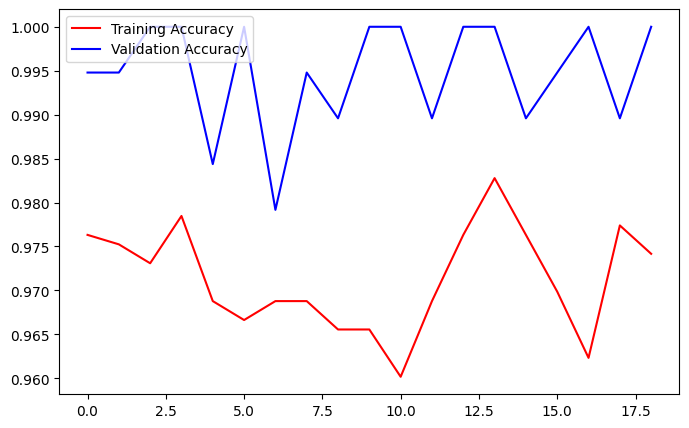

In [15]:
# Plot training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'r', label="Training Accuracy")
plt.plot(epochs, val_acc, 'b', label="Validation Accuracy")
plt.legend(loc='upper left')
plt.show()

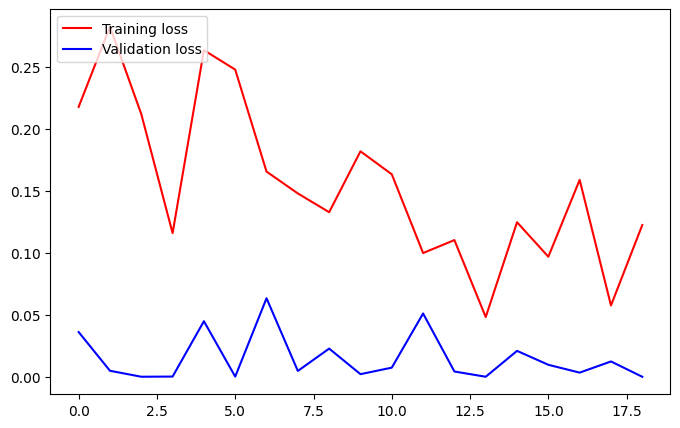

In [16]:
# Plot training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'r', label="Training loss")
plt.plot(epochs, val_loss, 'b', label="Validation loss")
plt.legend(loc='upper left')
plt.show()

In [ ]:
import numpy as np

# Assuming you have trained your model and defined the test_generator

# Get one batch of test data
test_data, test_labels = test_generator.next()

# Predict the labels for the test data
predictions = model.predict(test_data)

# Convert the predicted probabilities to class labels (0 or 1)
predicted_labels = np.round(predictions)

# Print the predicted labels and the true labels
print("Predicted Labels:", predicted_labels.flatten())
print("True Labels:", test_labels.flatten())



1/1 [==============================] - 1s 624ms/step
Predicted Labels: [1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 1. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1.]
True Labels: [1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 1. 0. 0. 1. 1. 1. 0. 0. 1. 0. 1. 1. 1.
 1. 0. 0. 1. 1. 1. 0. 1.]


1/1 [==============================] - 0s 75ms/step


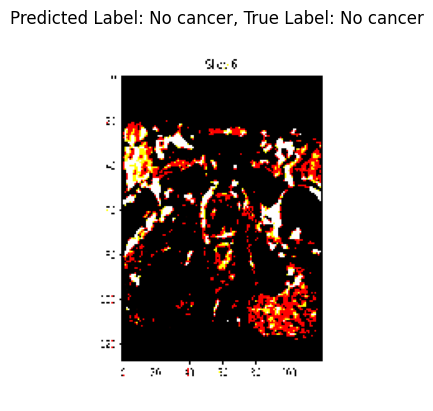

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Assuming you have trained your model and defined the test_generator

# Get one batch of test data
test_data, test_labels = test_generator.next()

# Get a random index within the batch size
random_index = np.random.randint(0, test_data.shape[0])

# Get the random image and its corresponding label
random_image = test_data[random_index]
true_label = test_labels[random_index]

# Expand the dimensions of the image to match the input shape expected by the model
random_image = np.expand_dims(random_image, axis=0)

# Predict the label for the random image
predicted_label = model.predict(random_image)
predicted_label = np.round(predicted_label)

# Convert label to human-readable format (0: No cancer, 1: Yes cancer)
labels_dict = {0: "No cancer", 1: "Yes cancer"}
predicted_label_str = labels_dict[int(predicted_label)]
true_label_str = labels_dict[int(true_label)]

# Display the random image
plt.imshow(random_image.squeeze(),  cmap='gray')
plt.title(f"Predicted Label: {predicted_label_str}, True Label: {true_label_str}")
plt.axis('off')
plt.show()


In [ ]:
from tensorflow.keras.models import load_model
# Load the model
loaded_model = load_model('/content/drive/MyDrive/Colab Notebooks/Dataset/Trained_model/model_vgg16_gen.h5')

1/1 [==============================] - 1s 1s/step


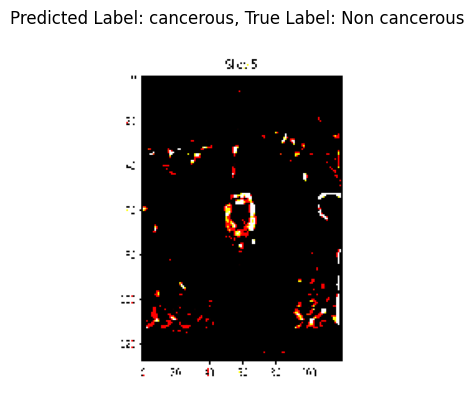

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)


# Assuming you have trained your model and defined the test_generator

# Get one batch of test data
test_data, test_labels = test_generator.next()

# Get a random index within the batch size
random_index = np.random.randint(0, test_data.shape[0])

# Get the random image and its corresponding label
random_image = test_data[random_index]
true_label = test_labels[random_index]

# Expand the dimensions of the image to match the input shape expected by the model
random_image = np.expand_dims(random_image, axis=0)

# Predict the label for the random image
predicted_label = model.predict(random_image)
predicted_label = np.round(predicted_label)

# Convert label to human-readable format (0: No cancer, 1: Yes cancer)
labels_dict = {0: "Non cancerous", 1: "cancerous"}
predicted_label_str = labels_dict[int(predicted_label)]
true_label_str = labels_dict[int(true_label)]

# Display the random image
plt.imshow(random_image.squeeze(),  cmap='gray')
plt.title(f"Predicted Label: {predicted_label_str}, True Label: {true_label_str}")
plt.axis('off')
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [ ]:
# Predict the labels for the entire test set
test_steps_per_epoch = np.math.ceil(test_generator.samples / test_generator.batch_size)
predictions = loaded_model.predict(test_generator, steps=test_steps_per_epoch)
predicted_labels = np.round(predictions).flatten()
true_labels = test_generator.classes

4/4 [==============================] - 77s 15s/step


In [ ]:
# Predict the labels for the entire train set
train_steps_per_epoch = np.math.ceil(train_generator.samples / train_generator.batch_size)
predictions = loaded_model.predict(train_generator, steps=train_steps_per_epoch)
predicted_labels = np.round(predictions).flatten()
true_labels = train_generator.classes

26/26 [==============================] - 549s 21s/step


In [ ]:
# Calculate performance metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)

# Print performance metrics
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

# Create a DataFrame for the metrics
metrics = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Score': [accuracy, precision, recall, f1]
}


Accuracy: 0.52
Precision: 0.52
Recall: 0.53
F1 Score: 0.52


In [ ]:
metrics_df = pd.DataFrame(metrics)
metrics_df

,Metric,Score
0,Accuracy,0.500000
1,Precision,0.500000
2,Recall,0.520000
3,F1 Score,0.509804
